In [119]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

df = pd.read_csv("data/ailerons.csv")

df = df.select_dtypes(include=['number'])

X = df.drop(columns=['goal'])
y = df['goal']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

mu_X = X_train.mean()
sigma_X = X_train.std()

X_train = (X_train - mu_X)/sigma_X
X_val = (X_val - mu_X)/sigma_X

X_train.insert(0, 'bias', 1)
X_val.insert(0, 'bias', 1)

### Linear Regression - Analytical Solution

In [120]:
import scipy
from sklearn.metrics import mean_squared_error

X = X_train.values
y = y_train.values

theta = scipy.linalg.inv(X.T @ X) @ X.T @ y

y_pred = X @ theta

rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE on training dataset: {rmse}")

X_v = X_val.values
y_v = y_val.values

y_pred_v = X_v @ theta
rmse_v = np.sqrt(mean_squared_error(y_v, y_pred_v))
print(f"RMSE on validation dataset: {rmse_v}")

RMSE on training dataset: 0.00017356964224212539
RMSE on validation dataset: 0.00017274101386956212


### Full Batch Gradient Descent

Epochs: 6061
Training RMSE: 0.0001747156574418647
Validation RMSE: 0.0001729137473962088


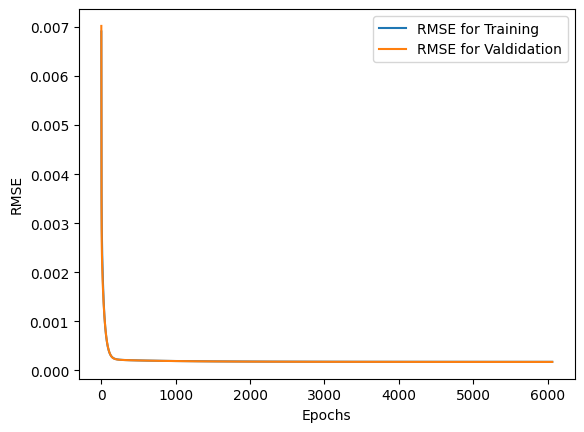

Total Training Time: 2.071197271347046 (s)


In [121]:
import time
import matplotlib.pyplot as plt

np.random.seed(10)

alpha = 0.01
CT = 1.001*rmse_v

d = X.shape[1]
theta_gd = np.random.rand(d)*0.001
training_hist, validation_hist = [], [np.inf]
epoch, max_epoch = 0, 100000

start_time = time.time()

while validation_hist[-1] >= CT and epoch < max_epoch:
  residuals = X @ theta_gd - y
  gradient = (2/X.shape[0])*(X.T @ residuals)

  theta_gd = theta_gd - alpha * gradient

  training_hist.append(np.sqrt(mean_squared_error(y, X @ theta_gd)))
  validation_hist.append(np.sqrt(mean_squared_error(y_v, X_v @ theta_gd)))

  epoch+=1

print(f"Epochs: {epoch}")
print(f"Training RMSE: {training_hist[-1]}")
print(f"Validation RMSE: {validation_hist[-1]}")

plt.figure()
plt.plot(range(1,epoch+1), training_hist, label="RMSE for Training")
plt.plot(range(1,epoch+1), validation_hist[1:], label="RMSE for Valdidation")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

print("Total Training Time: %s (s)" % (time.time() - start_time))

### Mini-batch and Stochastic Gradient Descent

In [122]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def mini_batch_gd(X_train, y_train, X_val, y_val, batch_size, alpha, CT):
    np.random.seed(5)

    X, y = X_train, y_train
    X_v, y_v = X_val, y_val

    d = X.shape[1]
    theta_mini_gd = np.random.uniform(0, 0.001, d)

    training_hist, validation_hist, times = [], [], []
    start_time = time.time()

    max_epochs = 10000
    epochs = 0
    threshold = 5
    violation = 0

    while ((len(validation_hist) == 0 or validation_hist[-1] > CT) 
                and epochs < max_epochs 
                and violation < threshold):
        
        index = np.random.permutation(X.shape[0])

        for start in range(0, X.shape[0], batch_size):
            indices = index[start:start + batch_size]
            X_batch = X[indices]
            y_batch = y[indices]

            residuals_batch = X_batch @ theta_mini_gd - y_batch
            gradient_batch = (2 / X_batch.shape[0]) * (X_batch.T @ residuals_batch)

            theta_mini_gd = theta_mini_gd - alpha * gradient_batch

        rmse_training = np.sqrt(mean_squared_error(y, X @ theta_mini_gd))
        rmse_validation = np.sqrt(mean_squared_error(y_v, X_v @ theta_mini_gd))
        
        training_hist.append(rmse_training)
        validation_hist.append(rmse_validation)
        times.append(time.time() - start_time)

        violation = violation + 1 if len(validation_hist) > 1 and rmse_validation > validation_hist[-2] else 0
        epochs += 1

    return theta_mini_gd, np.array(training_hist), np.array(validation_hist), np.array(times)

Batch size 2 did not converge.
Batch size 4 did not converge.
Batch size 8 did not converge.
Batch size 16 did not converge.
Batch size 32 did not converge.
Batch size 64 did not converge.
Batch size 128 did not converge.


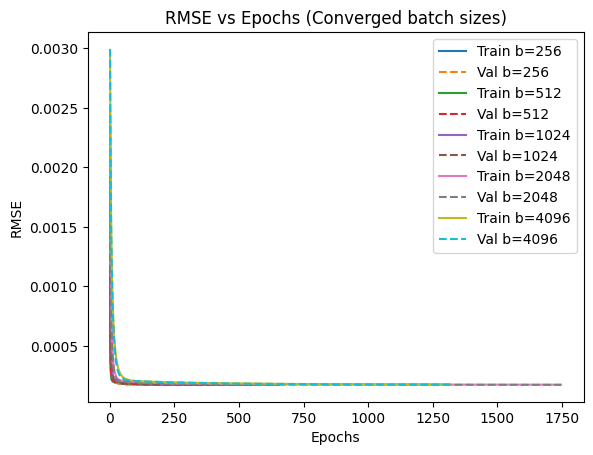

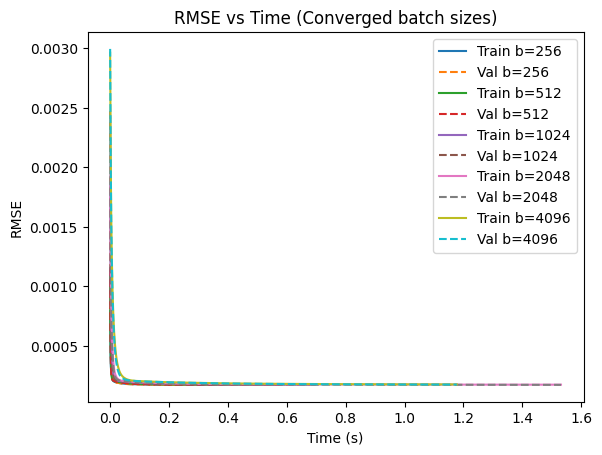

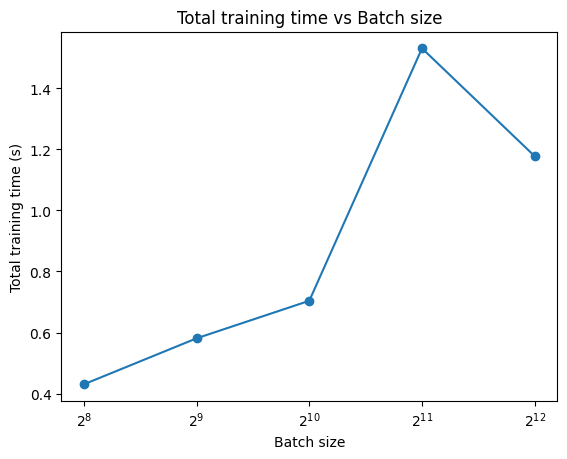

In [123]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
alpha = 0.015
results = {}
all_results = {}

for batch in batch_sizes:
    theta, training_arr, validation_arr, times_arr = mini_batch_gd(
        X, y, X_v, y_v, batch, alpha, 1.001*rmse_v
    )
        
    if (
        np.all(np.isfinite(validation_arr))  
        and len(validation_arr) > 1
        and validation_arr[-1] < validation_arr[0] 
        and validation_arr[-1] < 10 * validation_arr[0]  
    ):
        results[batch] = (training_arr, validation_arr, times_arr)
    else:
        print(f"Batch size {batch} did not converge.")
    
    all_results[batch] = (training_arr, validation_arr, times_arr)

plt.figure()
for batch, (training_arr, validation_arr, times_arr) in results.items():
    plt.plot(range(1, len(training_arr) + 1), training_arr, label=f"Train b={batch}")
    plt.plot(range(1, len(training_arr) + 1), validation_arr, linestyle="--", label=f"Val b={batch}")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE vs Epochs (Converged batch sizes)")
plt.show()

plt.figure()
for batch, (training_arr, validation_arr, times_arr) in results.items():
    plt.plot(times_arr, training_arr, label=f"Train b={batch}")
    plt.plot(times_arr, validation_arr, linestyle="--", label=f"Val b={batch}")
plt.xlabel("Time (s)")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE vs Time (Converged batch sizes)")
plt.show()

plt.figure()
batch_size = sorted(results.keys())
totals = [results[batch][2][-1] for batch in batch_size]
plt.plot(batch_size, totals, marker="o")
plt.xlabel("Batch size")
plt.ylabel("Total training time (s)")
plt.title("Total training time vs Batch size")
plt.xscale("log", base=2)
plt.show()

### Gradient Descent Learning Rate Investigation

In [124]:
def modified_mini_batch_gd(X_train, y_train, X_val, y_val, batch_size, alpha, CT):
    np.random.seed(5)

    X, y = X_train, y_train
    X_v, y_v = X_val, y_val

    d = X.shape[1]
    theta_mini_gd = np.random.uniform(0, 0.001, d)

    training_hist, validation_hist, times = [], [], []
    start_time = time.time()

    max_epochs = 10000
    epochs = 0
    threshold = 5
    violation = 0

    while ((len(validation_hist) == 0 or validation_hist[-1] > CT) 
                and epochs < max_epochs 
                and violation < threshold):
        
        index = np.random.permutation(X.shape[0])

        for start in range(0, X.shape[0], batch_size):
            indices = index[start:start + batch_size]
            X_batch = X[indices]
            y_batch = y[indices]

            residuals_batch = X_batch @ theta_mini_gd - y_batch
            gradient_batch = (2 / X_batch.shape[0]) * (X_batch.T @ residuals_batch)

            theta_mini_gd = theta_mini_gd - alpha * gradient_batch

        rmse_training = np.sqrt(mean_squared_error(y, X @ theta_mini_gd))
        rmse_validation = np.sqrt(mean_squared_error(y_v, X_v @ theta_mini_gd))
        
        training_hist.append(rmse_training)
        validation_hist.append(rmse_validation)
        times.append(time.time() - start_time)

        violation = violation + 1 if len(validation_hist) > 1 and rmse_validation > validation_hist[-2] else 0
        epochs += 1

    return theta_mini_gd, np.array(training_hist), np.array(validation_hist), np.array(times), training_hist[-1], validation_hist[-1]

In [125]:
non_converged_batches = [2,4,8]
coarse_learning_rates = np.logspace(-4, -2, 10)

for batch_size in non_converged_batches:
    results = []

    for clr in coarse_learning_rates:
        theta, training_arr, validation_arr, times_arr, rmse_training, rmse_validation = modified_mini_batch_gd(
            X, y, X_v, y_v, batch_size, clr, 1.001*rmse_v
        )
           
        results.append({
            "learning_rate": clr,
            "has_converged": (np.all(np.isfinite(validation_arr))  
                                and len(validation_arr) > 1
                                and validation_arr[-1] < validation_arr[0] 
                                and validation_arr[-1] < 10 * validation_arr[0]  
                            ),
            "training_rmse": rmse_training,
            "validation_rmse": rmse_validation
        })
        
    results_df = pd.DataFrame(results)
    print(f"BATCH SIZE: {batch_size}")
    print(results_df)
    print("\n")
    


BATCH SIZE: 2
   learning_rate  has_converged  training_rmse  validation_rmse
0       0.000100           True   1.744768e-04     1.728458e-04
1       0.000167          False   5.401341e-03     1.598234e-02
2       0.000278          False   3.240703e-01     9.703289e-01
3       0.000464          False   3.752377e+02     4.281980e+02
4       0.000774          False   4.134249e+04     7.020248e+03
5       0.001292          False   7.586824e+08     6.152041e+07
6       0.002154          False   9.758243e+14     1.299351e+14
7       0.003594          False   1.533216e+23     6.473551e+20
8       0.005995          False   1.083433e+30     6.984275e+27
9       0.010000          False   4.541476e+37     2.435491e+35


BATCH SIZE: 4
   learning_rate  has_converged  training_rmse  validation_rmse
0       0.000100           True   1.744070e-04     1.728714e-04
1       0.000167           True   1.744436e-04     1.728425e-04
2       0.000278          False   9.307784e-04     2.672114e-03
3       0.

In [126]:
fastest_batch = 256
coarse_learning_rates_2 = np.logspace(-4,-2,10)
results = []

for clr in coarse_learning_rates_2:
    theta, training_arr, validation_arr, times_arr, rmse_training, rmse_validation = modified_mini_batch_gd(
            X, y, X_v, y_v, fastest_batch, clr, 1.001*rmse_v
        )
    
    results.append({
            "learning_rate": clr,
            "has_converged": (np.all(np.isfinite(validation_arr))  
                                and len(validation_arr) > 1
                                and validation_arr[-1] < validation_arr[0] 
                                and validation_arr[-1] < 10 * validation_arr[0]  
                            ),
            "training_rmse": rmse_training,
            "validation_rmse": rmse_validation
        })

results_2_df = pd.DataFrame(results)
     

In [127]:
print(results_2_df)

   learning_rate  has_converged  training_rmse  validation_rmse
0       0.000100           True       0.000179         0.000177
1       0.000167           True       0.000177         0.000175
2       0.000278           True       0.000175         0.000174
3       0.000464           True       0.000174         0.000173
4       0.000774           True       0.000175         0.000173
5       0.001292           True       0.000174         0.000173
6       0.002154           True       0.000177         0.000175
7       0.003594           True       0.000175         0.000173
8       0.005995           True       0.000174         0.000173
9       0.010000           True       0.000174         0.000173
